In [1]:
from nets import UNet
from downloads import download_data, unzip_data
from datasets import Cell_Challenge_Segmentation_Dataset
from training import train_UNet, EarlyStopping
from segmentation import post_processing
from visualization import plot_mini_batch

import os

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as alb

### Frame alignment

In [12]:
import numpy as np

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [13]:
from scipy.optimize import linear_sum_assignment

def track_cells(previous_masks, current_masks):
    num_previous_cells = len(np.unique(previous_masks)) - 1
    num_current_cells = len(np.unique(current_masks)) - 1

    cost_matrix = np.zeros((num_previous_cells, num_current_cells))
    for i, id_pr in enumerate(np.unique(previous_masks)[1:]):
        for j, id_cr in enumerate(np.unique(current_masks)[1:]):
            pr_mask = previous_masks * (previous_masks==id_pr)
            cr_mask = current_masks * (current_masks==id_cr)
            cost_matrix[i, j] = 1 - calculate_iou(pr_mask, cr_mask)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignments = [(previous_cell, current_cell) for previous_cell, current_cell in zip(row_ind, col_ind) if cost_matrix[previous_cell,current_cell] != 1]

    return assignments

In [14]:
frames = last

track = np.zeros((len(frames),432,512)).astype(np.uint8)

# img = tiff.imread(os.path.join(path, frames[0]))[0].astype(np.uint8)
img = frames[0]

ids_pr = np.unique(img)[1:] # [1, 4, 7, 10, ...]
copy = img.copy()
for i, id in enumerate(ids_pr, start=1):
    copy[copy==id] = i

ids_pr = np.unique(copy)[1:] # [1, 2, 3, 4, ...]
track[0] = copy

next_id = np.max(ids_pr) + 1 # 11
for idx, frame in enumerate(frames[1:], start=1):
    # img = tiff.imread(os.path.join(path, frame))[0].astype(np.uint8) # new frame
    img = frame

    assignments = track_cells(track[idx-1], img)

    ids_pr = np.unique(track[idx-1])[1:]
    ids_cr = np.unique(img)[1:] # new labels
    copy = img.copy() # new frame reassigned
    crs = []
    for pr, cr in assignments:
        copy[img==ids_cr[cr]] = ids_pr[pr]
        crs.append(cr)
    
    if len(ids_cr) > len(ids_pr):
        # ids_cr = np.arange(1,next_id+1)
        for out_idx in ids_cr:
            if out_idx not in ids_cr[crs]:
                copy[img==out_idx] = next_id
                next_id += 1
    
    track[idx] = copy

### Centroid tracking

In [32]:
import cv2
import numpy as np

# Define a function to compute the centroid of a binary mask
def compute_centroid(mask):
    moments = cv2.moments(mask)
    centroid_x = int(moments["m10"] / moments["m00"])
    centroid_y = int(moments["m01"] / moments["m00"])
    return centroid_x, centroid_y

In [33]:
# Perform centroid-based tracking
num_frames = len(track)
frames = []

ids_max = [np.max(np.unique(i)) for i in track]
num_points = max(ids_max)

x_coords = np.zeros((num_frames, num_points))
y_coords = np.zeros((num_frames, num_points))

for frame_idx in range(num_frames):
    current_frame = track[frame_idx]
    ids = np.unique(current_frame)[1:]
    num_cells = len(ids)

    # Iterate over each cell in the current frame
    for cell_idx, cell_id in enumerate(ids):
        # Create a binary mask for the current cell
        cell_mask = np.uint8(current_frame == cell_id)

        # Compute the centroid of the cell
        x_coord, y_coord = compute_centroid(cell_mask)

        x_coords[frame_idx, cell_id-1] = x_coord
        y_coords[frame_idx, cell_id-1] = y_coord

### Create Jpeg and videos from tracked arrays

In [75]:
from PIL import Image

In [214]:
colors = np.random.randint(0, 255, size=(30, 3), dtype=np.uint8)
for idx, frame in enumerate(track):
    ids = np.unique(frame)[1:]
    num = len(ids)
    im1 = np.zeros((432,512)).astype(np.uint8)
    im2 = np.zeros((432,512)).astype(np.uint8)
    im3 = np.zeros((432,512)).astype(np.uint8)
    for i, id in enumerate(ids):
        im1[frame==id], im2[frame==id], im3[frame==id] = colors[id-1]

    im = np.zeros((432,512,3)).astype(np.uint8)
    im[:,:,0], im[:,:,1], im[:,:,2] = im1, im2, im3

    img = Image.fromarray(im, 'RGB')
    img.save(f'content/Segmentation/challenge_data/Fluo-N3DH-CHO/01_LB/{idx: 04d}.jpeg')

In [116]:
from visualization import create_video
input_path = "content/Segmentation/challenge_data/Fluo-N3DH-CHO/01_LB"
output_path = "content/Segmentation/challenge_data/Fluo-N3DH-CHO/videos/01_LB_video.mp4"
fps = 10
create_video(input_path, output_path, fps)

In [117]:
input_path = "content/Segmentation/challenge_data/Fluo-N3DH-CHO/01"
output_path = "content/Segmentation/challenge_data/Fluo-N3DH-CHO/videos/01_video.mp4"
fps = 10
create_video(input_path, output_path, fps)

### Video of centroid tracking

In [208]:
import cv2
import numpy as np
from PIL import Image

def create_trajectory_video(centroids, frame_shape):
    num_frames = len(centroids)
    num_cells = len(centroids[0])
    colors = [tuple([np.random.randint(255),np.random.randint(255),np.random.randint(255)]) for i in range(num_cells)]
    # Iterate over each frame and draw the cell trajectories
    for frame_idx in range(num_frames):
        frame = np.zeros(frame_shape, dtype=np.uint8)  # Create an empty frame

        for cr_frame_idx, cr_frame in enumerate(centroids[:frame_idx]):

            # Draw the trajectories on the frame
            for cell_idx, centroid in enumerate(cr_frame):
                # Draw a circle at the centroid position
                if centroid != (0, 0):
                    cv2.circle(img=frame, center=centroid, radius=3, color=colors[cell_idx], thickness=-1)
                
                    if centroids[cr_frame_idx-1][cell_idx] != (0, 0) and cr_frame_idx > 0:
                        cv2.line(img=frame, pt1=centroids[cr_frame_idx-1][cell_idx], pt2=centroid, color=colors[cell_idx], thickness=3) 

        for cell_idx, centroid in enumerate(centroids[frame_idx]):
            # Draw a circle at the centroid position
            if centroid != (0, 0):
                cv2.circle(img=frame, center=centroid, radius=3, color=colors[cell_idx], thickness=-1)
                cv2.putText(img=frame, text=f"{cell_idx}", org=centroid, fontFace=3, fontScale=0.5, color=(255,255,255))

        img = Image.fromarray(frame, 'RGB')
        img.save(f'pruebas/{frame_idx: 04d}.jpeg')

    return

In [209]:
# Example usage
coordinates = [[(int(i),int(j)) for i,j in zip(k, l)] for k,l in zip(x_coords, y_coords)]
frame_shape = (432, 512, 3)

create_trajectory_video(coordinates, frame_shape)

In [210]:
from visualization import create_video

In [211]:
create_video("pruebas", "pruebas/video.mp4", 10)

### Trajectory plots

In [53]:
import plotly.graph_objects as go
import numpy as np

colors = np.random.choice(range(256), size=(num_points, 3), replace=True)
marker_colors = [colors[i] for i in range(num_points) for _ in range(num_frames)]

# Create the initial scatter plot with the first frame's coordinates
fig = go.Figure(
    data=go.Scatter(
        x=x_coords_filtered[0],
        y=y_coords_filtered[0],
        mode="markers",
        marker=dict(
            size=8,
            color=x_coords_filtered[0],
            # opacity=0.8,
            # colorscale="Viridis"
        ),
        showlegend=False
    ),
    layout=go.Layout(
        width=512,
        height=432,
        autosize=False,
        xaxis=dict(range=[0, 512]),
        yaxis=dict(range=[0, 432], scaleanchor="x", scaleratio=1),
        title="Points Animation"
    ),
    frames=[go.Frame(data=[go.Scatter(x=x_coords_filtered[i], y=y_coords_filtered[i])]) for i in range(1, num_frames)]
)

# Add play and pause buttons to control the animation
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            type="buttons",
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True, "mode": "immediate"}]
                ),
                dict(
                    label="Pause",
                    method="animate",
                    args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}]
                )
            ],
            showactive=False,
            direction="left",
            pad={"r": 10, "t": 10},
            x=0.1,
            xanchor="right",
            y=0,
            yanchor="top"
        ),
    ]
)

# Show the figure
fig.show()


In [43]:
nonzero_indices = np.logical_and(x_coords != 0, y_coords != 0)
x_coords_filtered = np.where(nonzero_indices, x_coords, np.nan)
y_coords_filtered = np.where(nonzero_indices, y_coords, np.nan)

In [10]:
import cv2

prev_labels, num_labels = cv2.connectedComponents((last[1]>0).astype(np.uint8))

In [14]:
max(np.unique(last[1]))

10

In [11]:
prev_labels

8

In [18]:
np.unique(last[1])

array([ 0,  2,  3,  5,  6,  8,  9, 10])

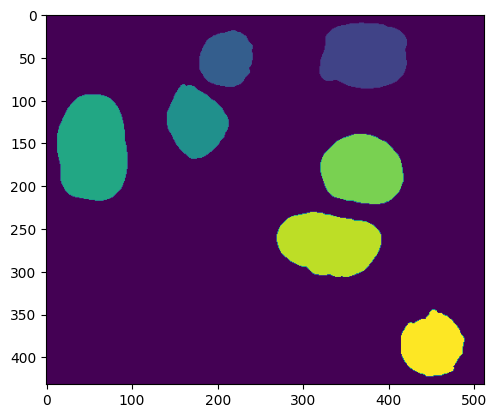

In [17]:
plt.imshow(last[1])

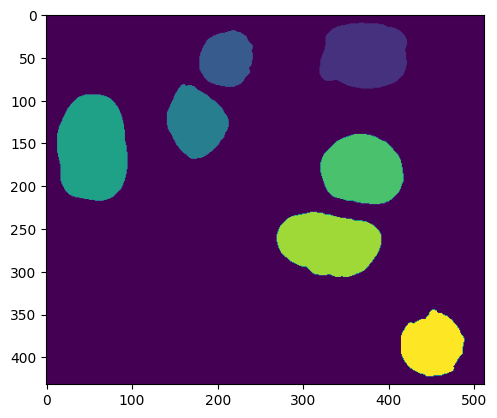

In [16]:
plt.imshow(num_labels)

In [ ]:
import cv2
import numpy as np

def separate_touching_cells(prev_mask, current_mask):
    # Compare binary masks of consecutive frames
    touching_pixels = np.logical_and(current_mask, prev_mask)
    
    # Label connected components in previous frame
    prev_labels, num_labels = cv2.connectedComponents(prev_mask.astype(np.uint8))
    
    # Create a new mask for the current frame
    separated_mask = np.zeros_like(current_mask)
    
    # Iterate through the touching pixels and assign labels based on proximity in the previous frame
    for label in range(1, num_labels):
        # Find the coordinates of the touching pixels for the current label
        touching_coords = np.where(touching_pixels & (prev_labels == label))
        
        if touching_coords[0].size > 0:
            # Find the centroid of the touching pixels
            centroid = (int(np.mean(touching_coords[1])), int(np.mean(touching_coords[0])))
            
            # Assign a new label to the separated cell in the current frame
            separated_mask[centroid[1], centroid[0]] = 1
    
    return separated_mask

# Example usage
# prev_frame: binary mask of the previous frame
# current_frame: binary mask of the current frame
separated_cells = separate_touching_cells(prev_frame, current_frame)


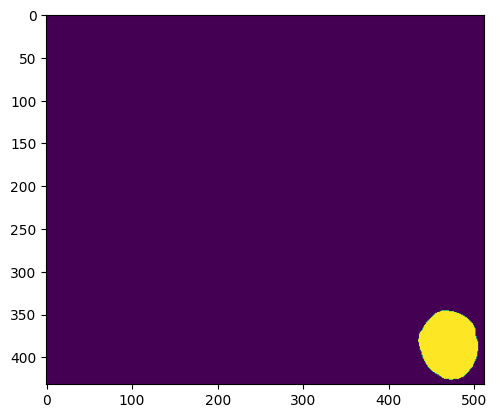

In [31]:
pr_mask = last[0] * (last[0] == 9)
plt.imshow(pr_mask)

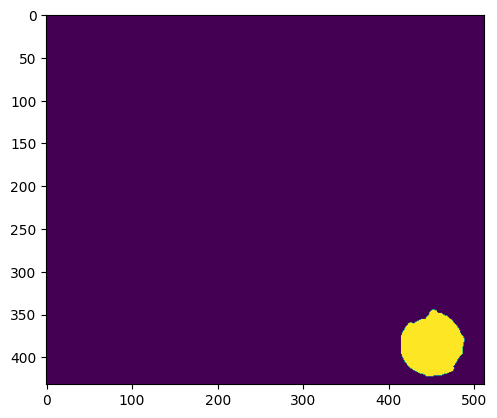

In [32]:
cr_mask = last[1] * (last[1] == 10)
plt.imshow(cr_mask)

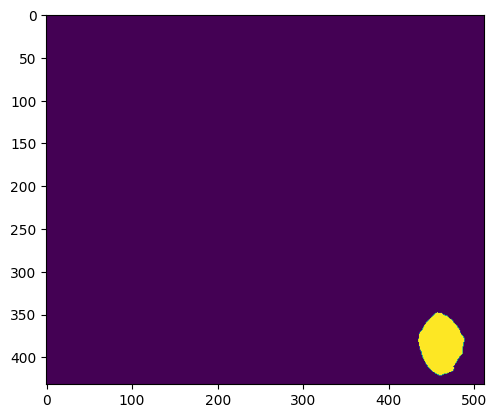

In [34]:
touching_pixels = np.logical_and(cr_mask, (pr_mask))
plt.imshow(touching_pixels)